## Setup
Install and import dependencies and set random state seed value.

In [1]:
"""
%pip install pyreadr

%pip install scikit-learn
%pip install xgboost

%pip install -U matplotlib
%pip install typeguard
"""

'\n%pip install pyreadr\n\n%pip install scikit-learn\n%pip install xgboost\n\n%pip install -U matplotlib\n%pip install typeguard\n'

In [2]:
# library to check function types of imported modules
from typeguard import install_import_hook

# custom functions for plotting, etc.
with install_import_hook('custom_ml_plots'):
    import custom_ml_plots as cmp
with install_import_hook('custom_dataset_tools'):
    import custom_dataset_tools as cdt
with install_import_hook('basic_ml_operations'):
    import basic_ml_operations as bmo

# data import
import pyreadr

# basic math libraries
import pandas as pd

# Scaling
from sklearn.preprocessing import StandardScaler

# global parameters
RANDOM_STATE = 42
TEST_SET_PORTION = 0.15
CV_SET_PORTION = 0.15
TOP_LINE_THRESH = 0.8

## Import Data

In [3]:
# import dataset
eyt1 = pyreadr.read_r('./data/eyt1.RData')

# extract training example labels
y = eyt1['Pheno_Disc_Env1']

y.head()

,GID,Env,DTHD,DTMT,GY,Height
0,GID6569128,Bed5IR,1.0,1.0,6.119272,0.0
1,GID6688880,Bed5IR,2.0,2.0,5.855879,0.0
2,GID6688916,Bed5IR,2.0,2.0,6.434748,0.0
3,GID6688933,Bed5IR,2.0,2.0,6.350670,0.0
4,GID6688934,Bed5IR,1.0,2.0,6.523289,0.0


In [4]:
# sort by ID, drop unneeded column describing planting environment
y = y.sort_values(by=y.columns[0])
y = y.drop('Env', axis=1)

# Extract gene IDs from first column and set them as the row labels for y
y = cdt.first_col_to_row_labels(y)

# Save row and col labels for future use
gene_labels = y.index
target_labels = y.columns

# check missing values
cdt.assert_no_bad_values(y)

# each seed was planted in 4 different environments, but we don't care about environmental differences
# so we take the average of every group of four rows to reduce the dataset to 1/4 its original size
gene_labels = gene_labels[::4]
y = cdt.avg_rows(y, 4)

y.head()

,DTHD,DTMT,GY,Height
GID,,,,
GID6569128,1.75,1.50,5.160521,0.75
GID6688880,2.25,2.50,5.988963,0.25
GID6688916,2.00,2.00,5.781745,0.00
GID6688933,2.00,2.25,5.434369,0.00
GID6688934,1.75,1.75,5.551610,0.00


In [5]:
# extract feature matrix
X = eyt1['Geno_Env1']

X.head()

,GID6569128,GID6688880,GID6688916,GID6688933,GID6688934,GID6688949,GID6689407,GID6689482,GID6689550,GID6738288,...,GID6939899,GID6939900,GID6939902,GID6939903,GID6939904,GID6939917,GID6939919,GID6939938,GID6939941,GID6939945
GID6569128,0.788801,-0.006443,0.025987,-0.138795,-0.157880,0.096213,-0.110899,0.013069,-0.040445,0.007931,...,0.125612,0.133808,0.137456,0.127674,0.130468,0.004096,0.091188,0.074009,0.032992,0.199459
GID6688880,-0.006443,0.980542,0.064585,-0.168773,-0.081006,0.078890,-0.201346,0.124671,0.253505,0.013636,...,0.072171,0.061650,0.057898,0.079085,0.061086,0.104630,0.113878,0.108757,0.154718,0.004447
GID6688916,0.025987,0.064585,1.170073,-0.021636,-0.031717,0.101532,-0.196780,0.041900,-0.013459,0.126464,...,0.428609,0.423184,0.427788,0.408326,0.426844,0.006038,0.209395,0.240468,0.255337,0.163524
GID6688933,-0.138795,-0.168773,-0.021636,0.879004,0.443678,-0.080560,0.402479,-0.218803,-0.102718,-0.002303,...,-0.079312,-0.087824,-0.089912,-0.067028,-0.084206,-0.140529,-0.088961,-0.096740,-0.159136,-0.108800
GID6688934,-0.157880,-0.081006,-0.031717,0.443678,0.996666,-0.140766,0.395843,-0.310471,-0.138902,0.088169,...,-0.016690,-0.017375,-0.026372,-0.014478,-0.016350,-0.098509,-0.052304,-0.012778,-0.100318,-0.154557


In [6]:
# split feature matrix into training, CV & test sets
X_train, y_train, X_CV, y_CV, X_test, y_test = bmo.split(X, y, CV_SET_PORTION, TEST_SET_PORTION, RANDOM_STATE)

print(f"\n# TRAINING:")
print(f'\nX_train {X_train.shape}')
print(X_train.iloc[:5, :5])
print(f'\ny_train {y_train.shape}')
print(y_train.head())

print("\n# CV:")
print(f'\nX_CV {X_CV.shape}')
print(X_CV.iloc[:5, :5])
print(f'\ny_CV {y_CV.shape}')
print(y_CV.head())

print("\n# TEST:")
print(f'\nX_test {X_test.shape}')
print(X_test.iloc[:5, :5])
print(f'\ny_test {y_test.shape}')
print(y_test.head())



# TRAINING:

X_train (536, 766)
            GID6569128  GID6688880  GID6688916  GID6688933  GID6688934
GID6932344   -0.171129   -0.168244   -0.089790    0.411643    0.414066
GID6934811   -0.079326    0.084335    0.041316   -0.079128   -0.072265
GID6933384   -0.096709    0.101291   -0.012319   -0.106579   -0.140988
GID6861833   -0.031425    0.169809   -0.022846   -0.141453   -0.223245
GID6938839   -0.062001   -0.071951   -0.047728    0.226310    0.186815

y_train (536, 4)
            DTHD  DTMT        GY  Height
GID                                     
GID6932344  1.75  1.75  5.748453     0.0
GID6934811  2.25  2.00  5.165913     0.0
GID6933384  1.25  1.50  5.069249     0.5
GID6861833  3.00  3.00  5.918370     1.0
GID6938839  2.25  2.25  5.400628     0.0

# CV:

X_CV (115, 766)
            GID6569128  GID6688880  GID6688916  GID6688933  GID6688934
GID6932153    0.039072   -0.005196    0.001216   -0.129555   -0.205465
GID6937070   -0.018132   -0.040737    0.378104   -0.016398   -0.051146

In [7]:
# scale feature matrix
X_scaler = StandardScaler()
X_train_scaled = pd.DataFrame(X_scaler.fit_transform(X_train), index=X_train.index, columns=X_train.columns)

y_scaler = StandardScaler()
y_train_scaled = pd.DataFrame(y_scaler.fit_transform(y_train), index=y_train.index, columns=y_train.columns)

y_train_scaled.head()

,DTHD,DTMT,GY,Height
GID,,,,
GID6932344,-0.452039,-0.469973,0.662454,-1.575102
GID6934811,0.240227,-0.111133,-1.053812,-1.575102
GID6933384,-1.144306,-0.828813,-1.338602,-0.091350
GID6861833,1.278626,1.324226,1.163061,1.392401
GID6938839,0.240227,0.247707,-0.362298,-1.575102


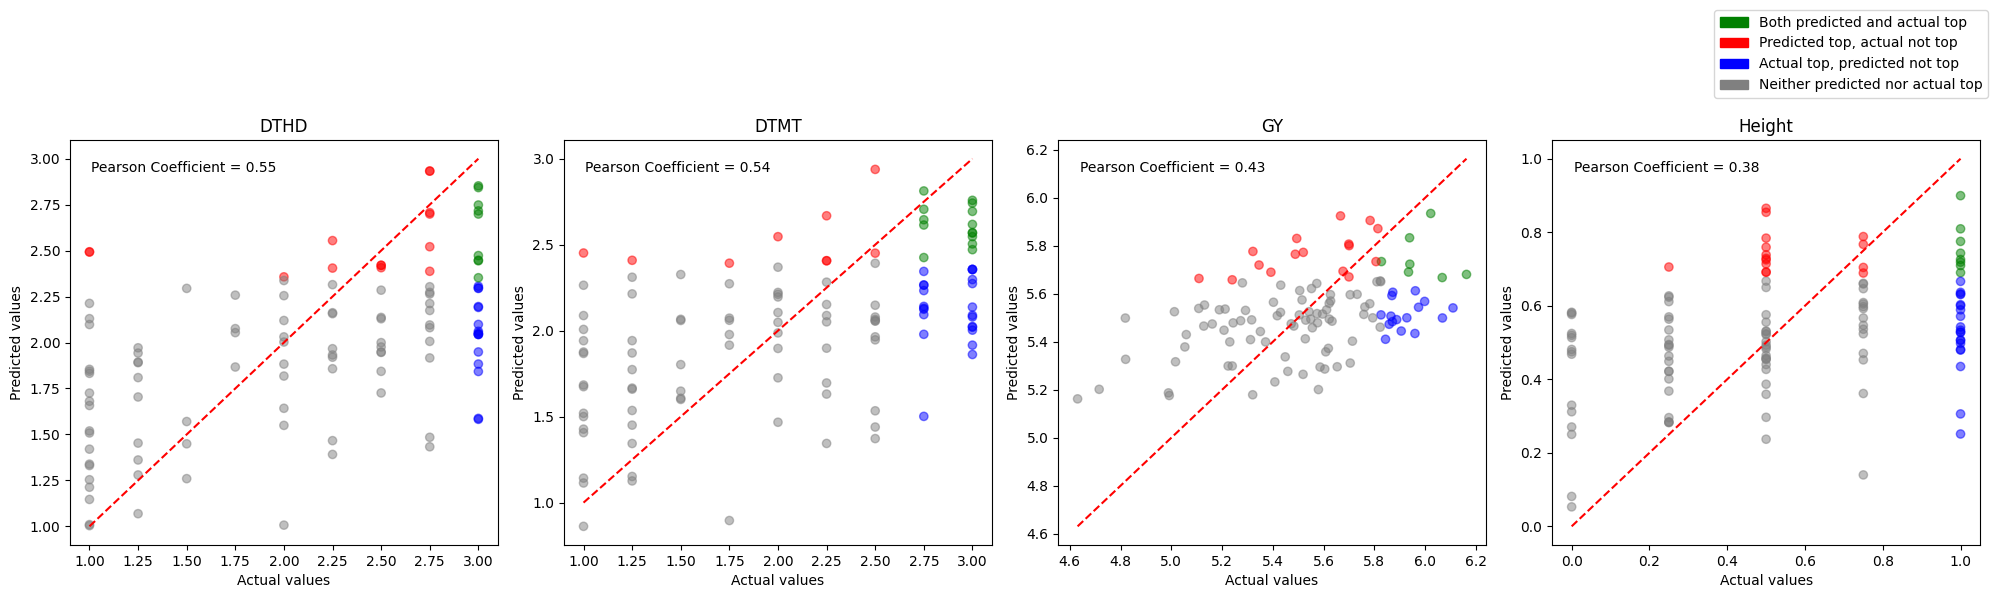

In [8]:
svr = bmo.train_SVR(X_train_scaled, y_train_scaled)

# Train a model with default parameters
X_test_scaled = pd.DataFrame(X_scaler.transform(X_test), index=X_test.index, columns=X_test.columns)

# predict, identify top lines and plot
y_pred = pd.DataFrame(y_scaler.inverse_transform(svr.predict(X_test_scaled)), columns=target_labels)
y_pred_top = cdt.classify_top(y_pred, TOP_LINE_THRESH)
y_test_top = cdt.classify_top(y_test, TOP_LINE_THRESH)
cmp.plot_predictions_vs_actuals(y_pred, y_test, y_pred_top, y_test_top)

## Grid search

In [9]:
"""# C values and kernels to try combos of
param_grid = {
    'gamma': bmo.power_list(2, -15, 3),
    'C': bmo.power_list(2, -4, 14)
}
"""

param_grid = {
    'gamma': bmo.power_list(2, 1, 2),
    'C': bmo.power_list(2, -1, 0)
}

# perform the grid search with SVR models
model_grid = bmo.grid_search(X_train, y_train, param_grid, bmo.train_SVR, kernel='rbf')

In [10]:
# plot results of grid search with column and row labels for the parameters trained on
cmp.plot_grid_search(X_CV, y_CV, param_grid, model_grid, 'DTHD')

IndexingError: Too many indexers

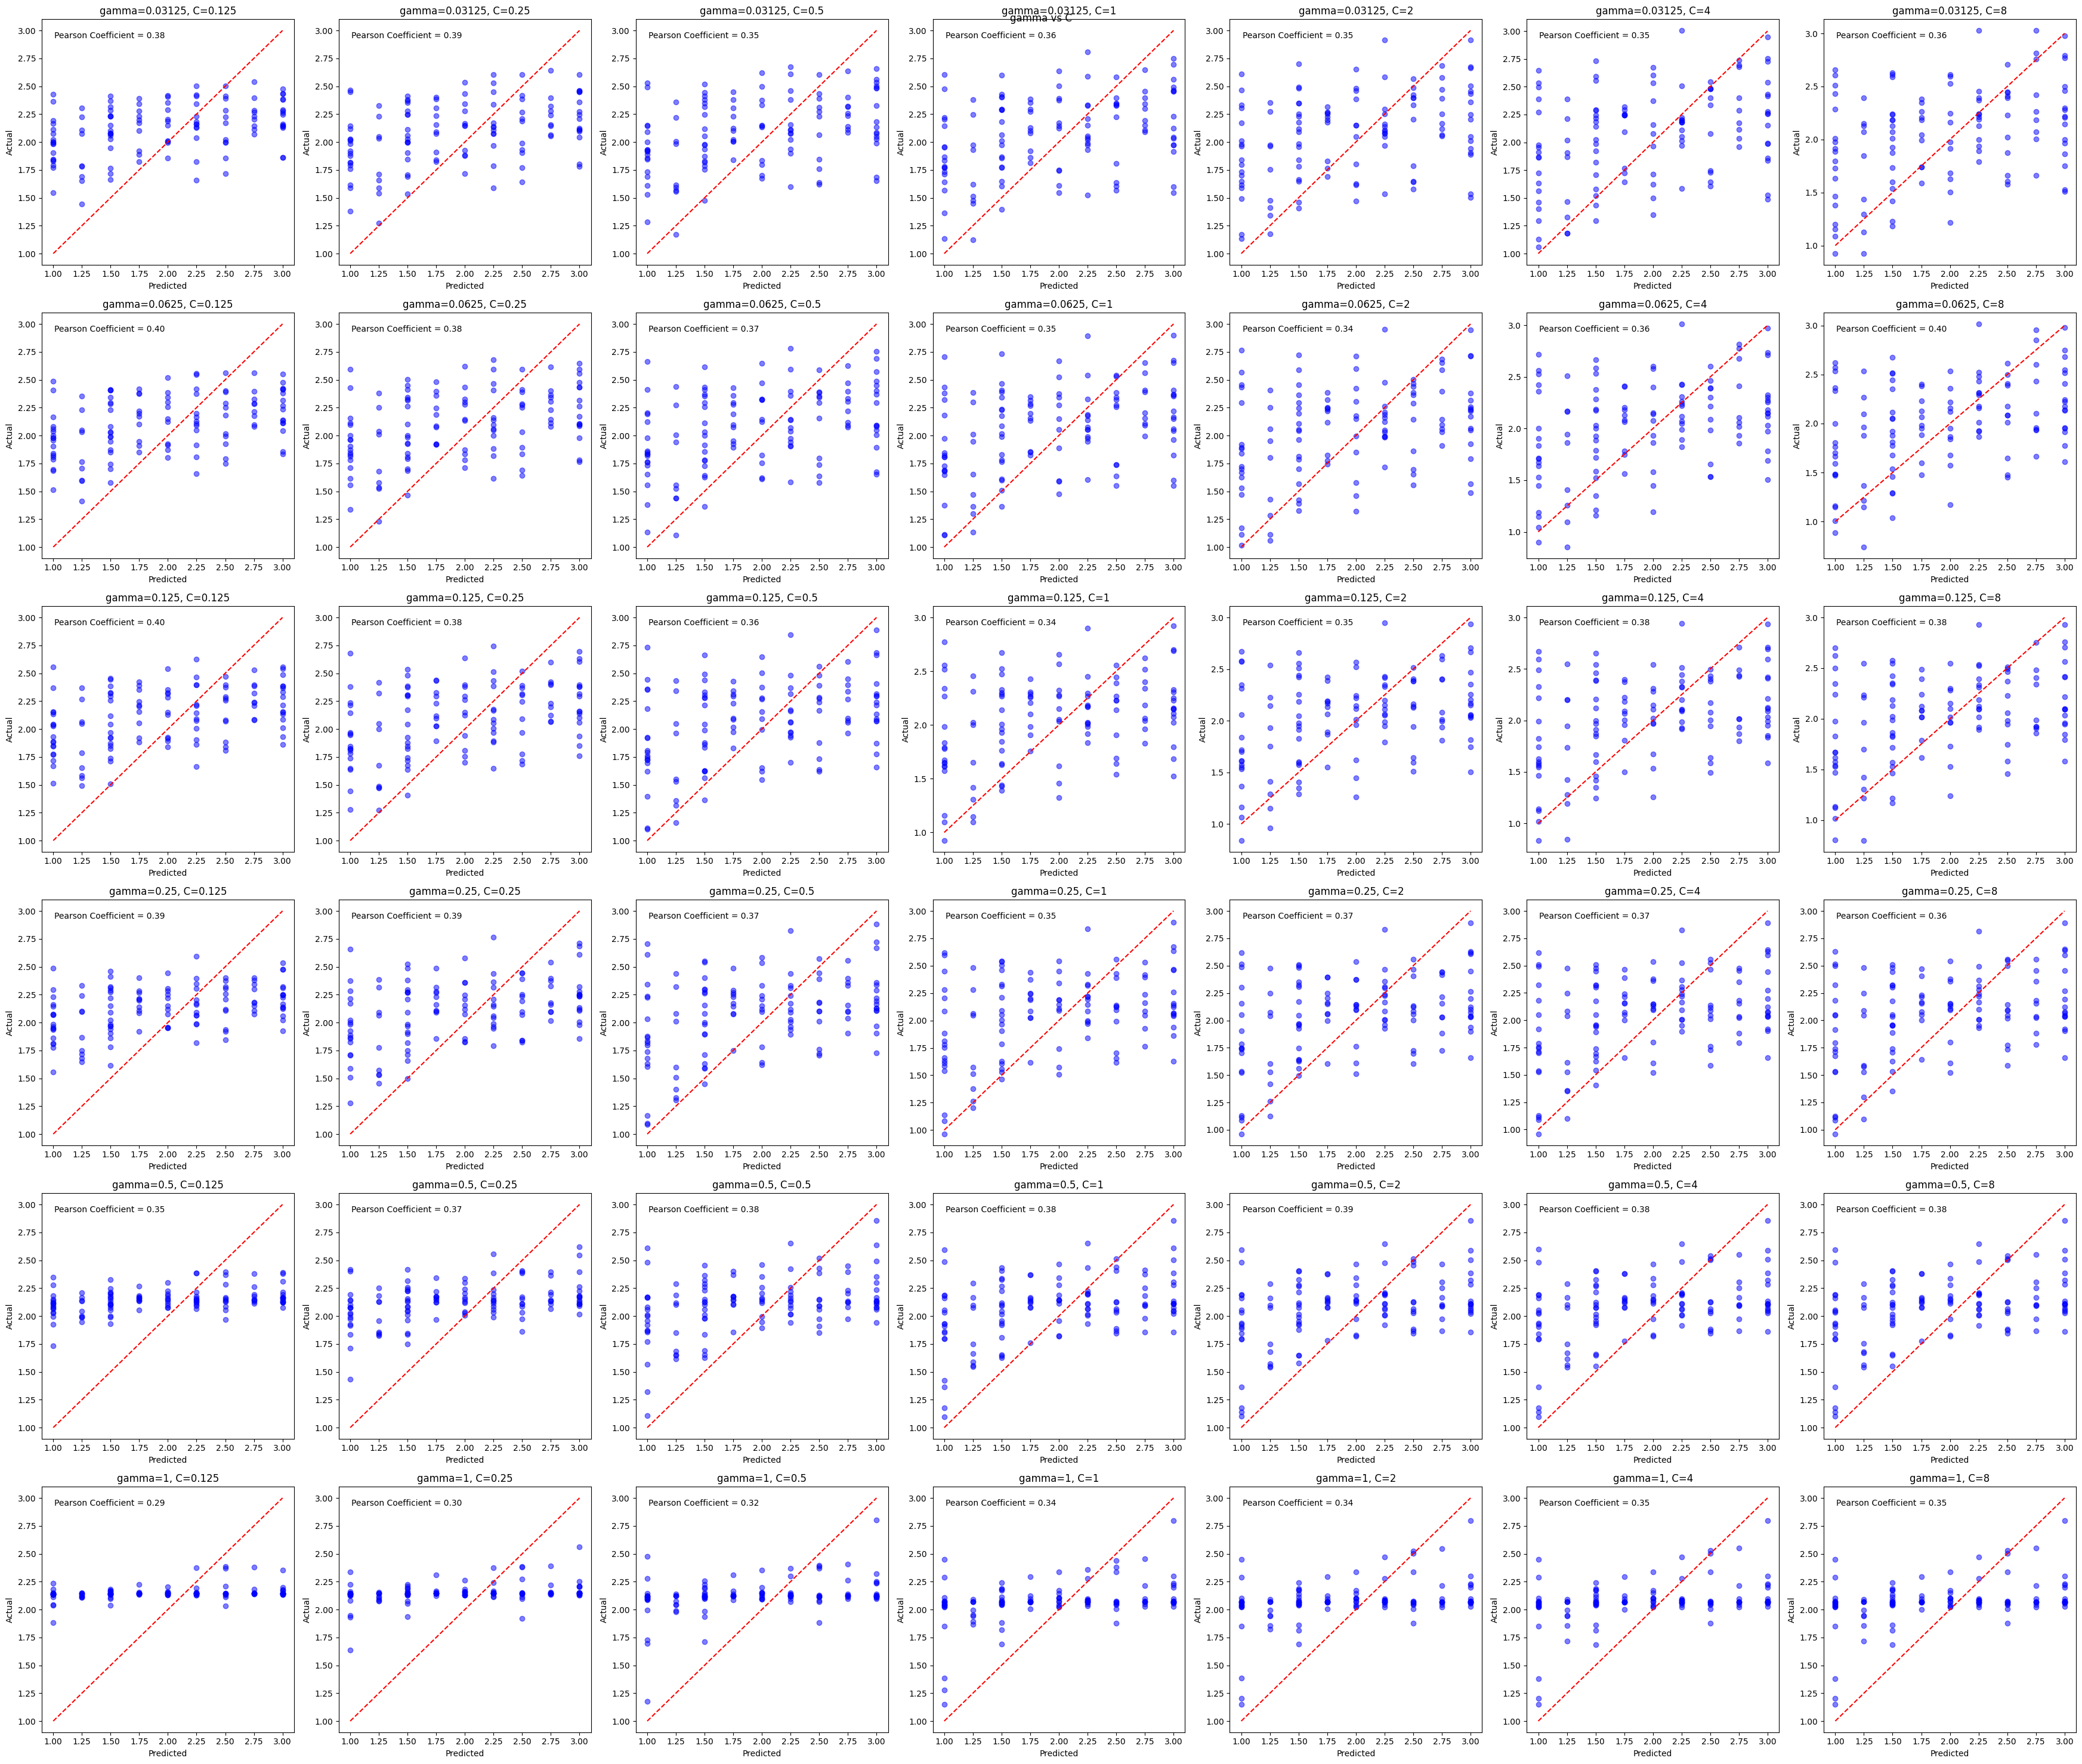

In [13]:
# plot results of grid search with column and row labels for the parameters trained on
cmp.plot_grid_search(X_CV, y_CV, param_grid, model_grid, 'DTMT')

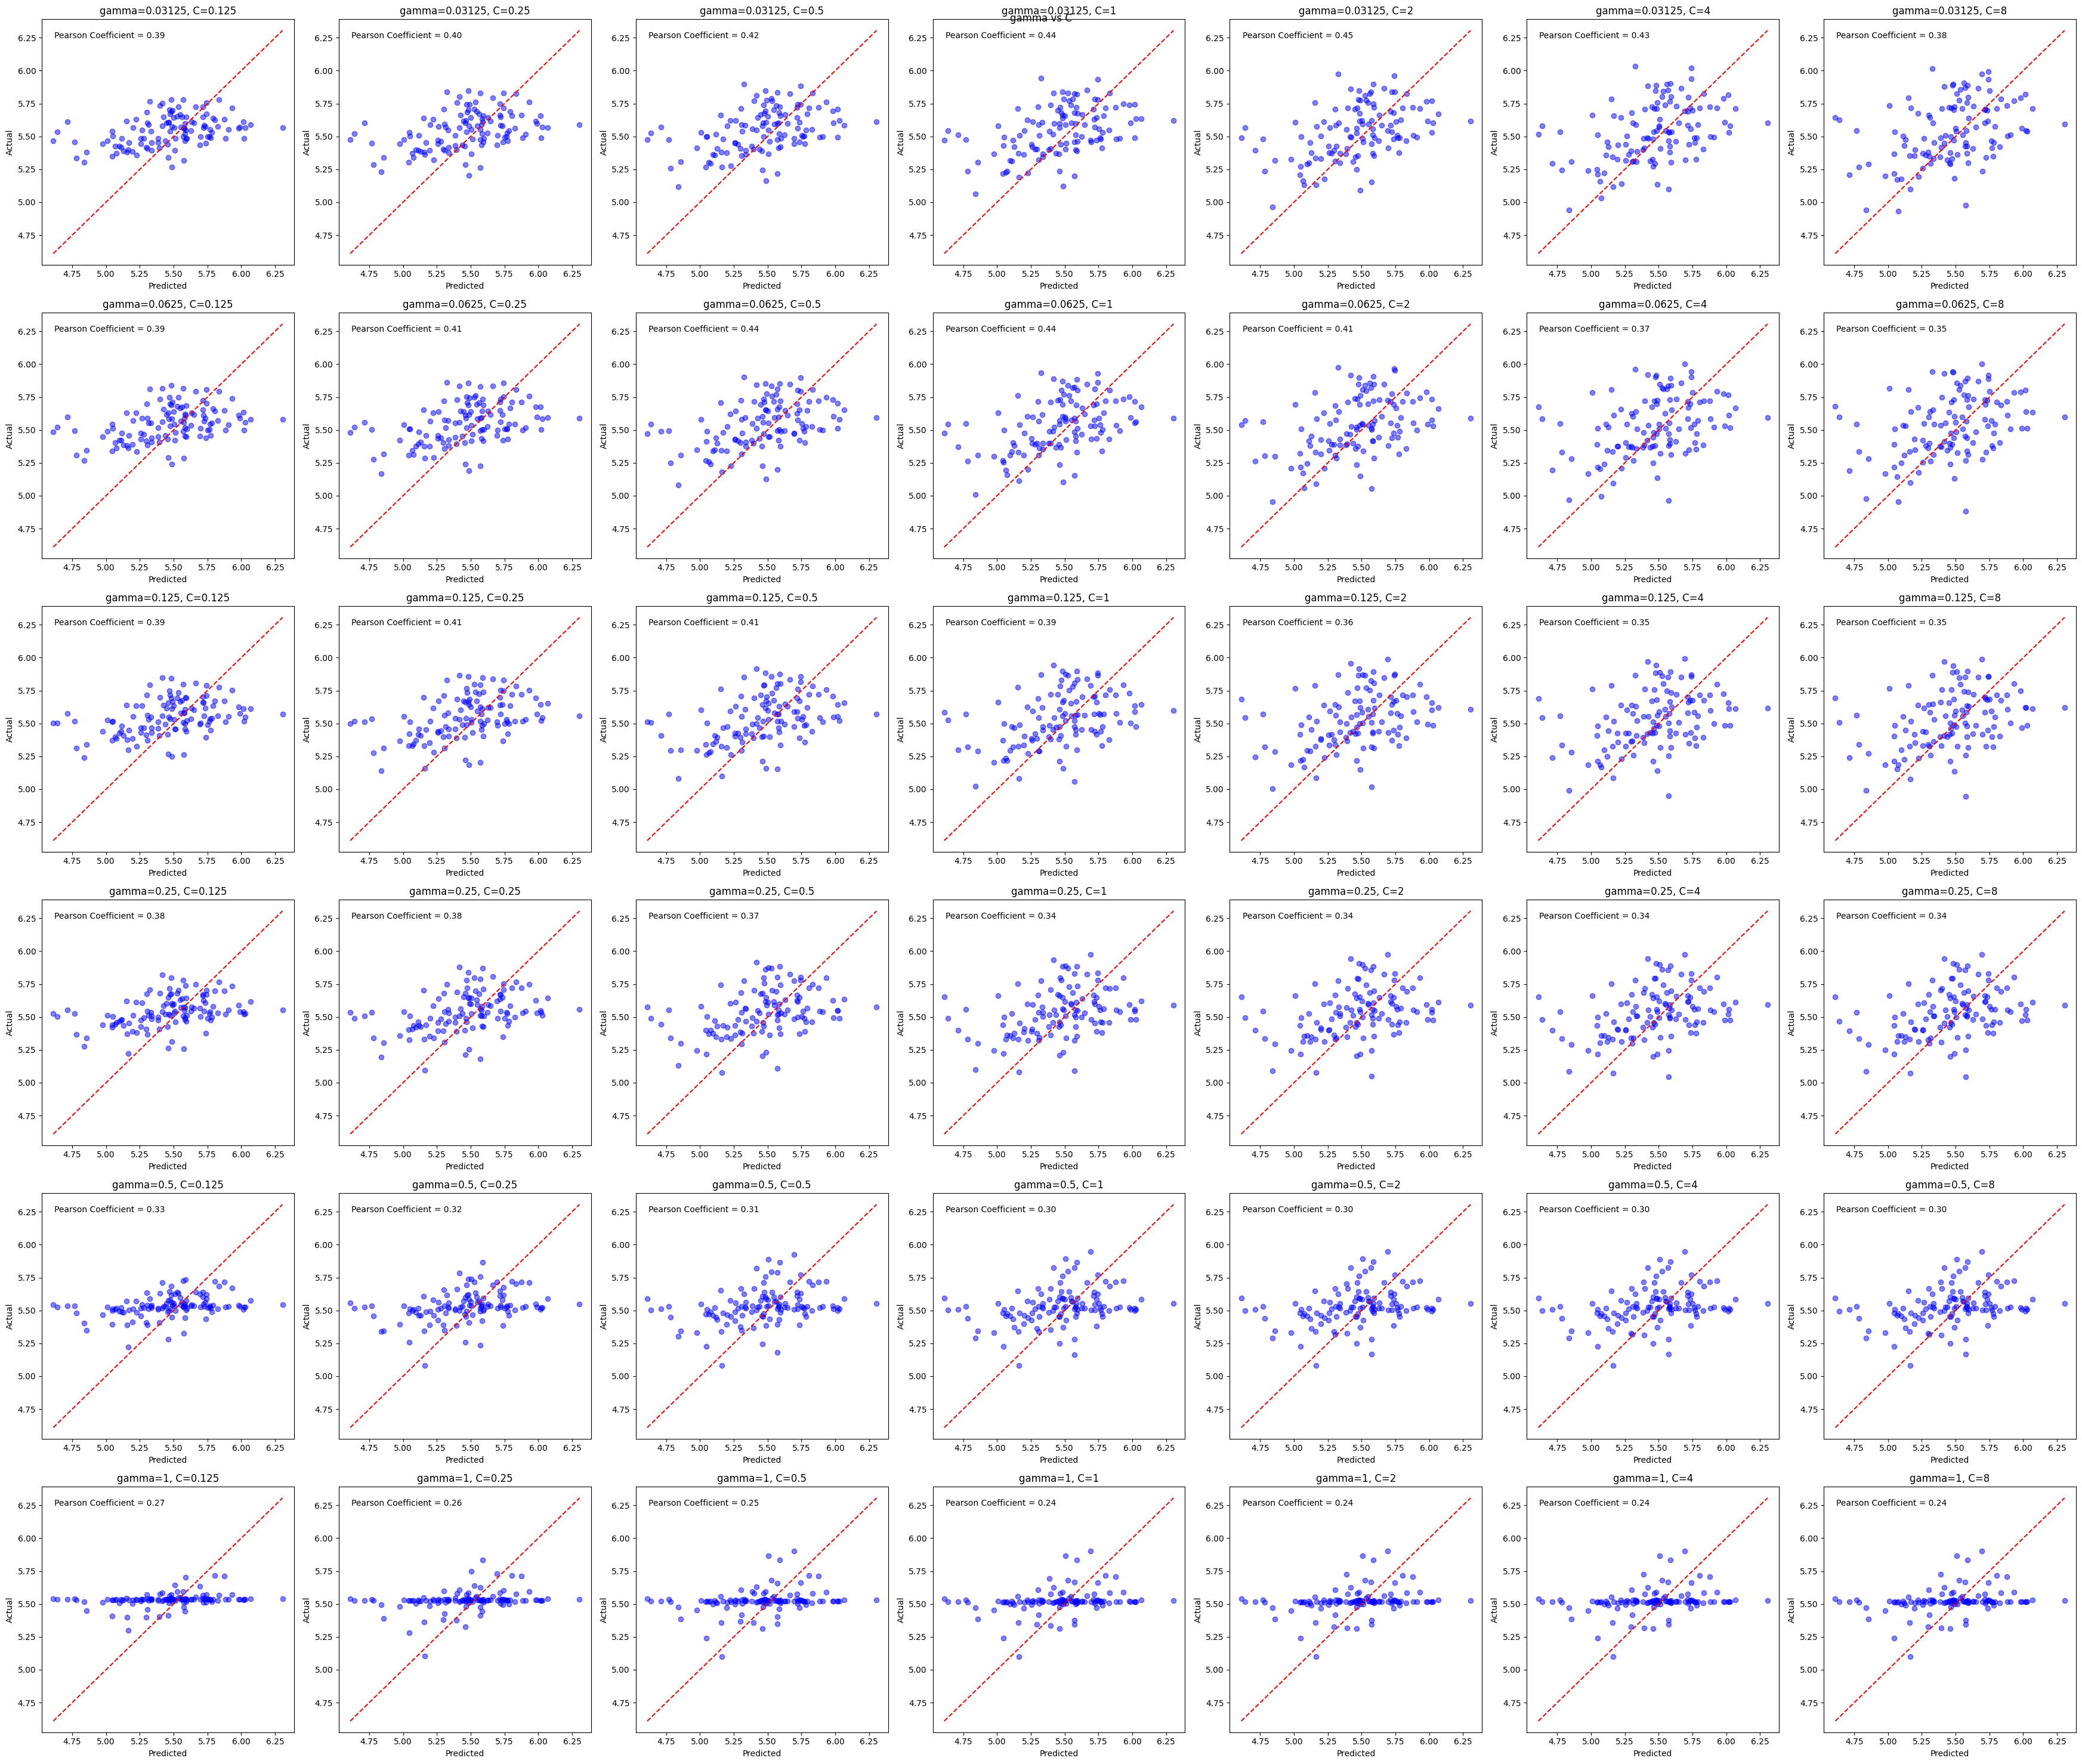

In [14]:
# plot results of grid search with column and row labels for the parameters trained on
cmp.plot_grid_search(X_CV, y_CV, param_grid, model_grid, 'GY')

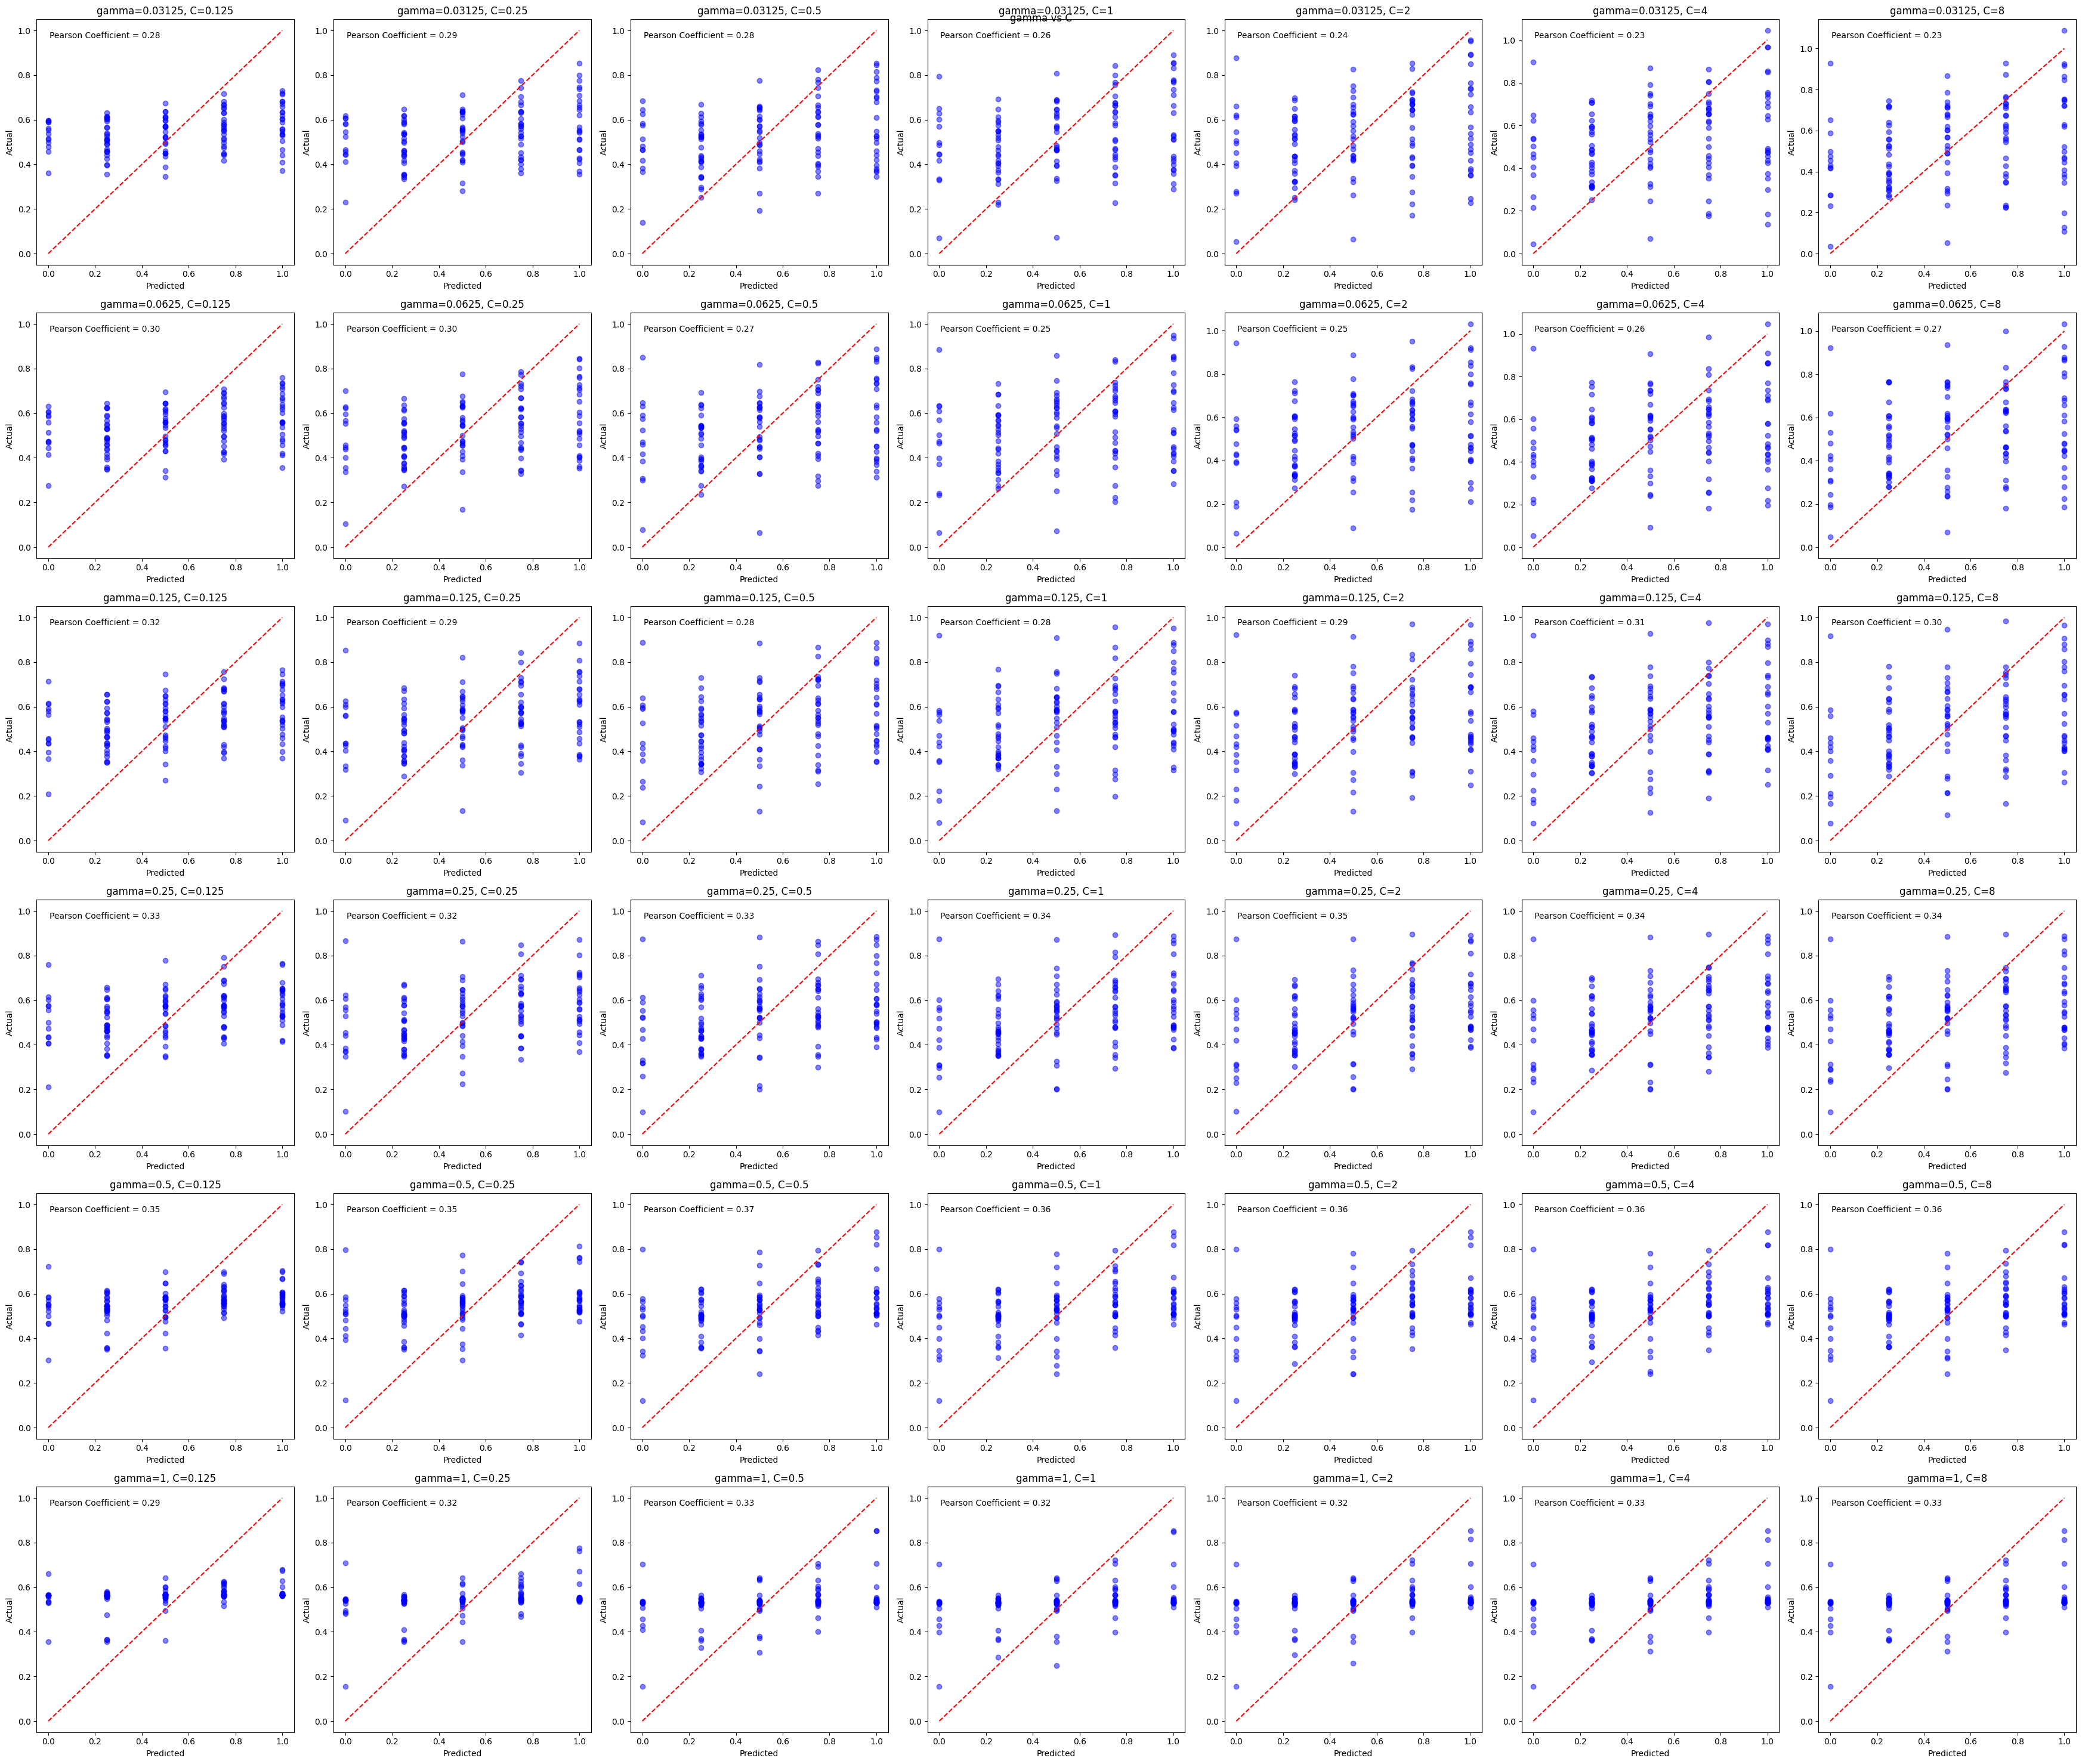

In [15]:
# plot results of grid search with column and row labels for the parameters trained on
cmp.plot_grid_search(X_CV, y_CV, param_grid, model_grid, 'Height')